In [119]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import gc
import re
import random
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error


In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
train_logs=pd.read_csv('/content/drive/MyDrive/IME672_Project/linking-writing-processes-to-writing-quality/train_logs.csv')
train_scores=pd.read_csv('/content/drive/MyDrive/IME672_Project/linking-writing-processes-to-writing-quality/train_scores.csv')
test_logs=pd.read_csv('/content/drive/MyDrive/IME672_Project/linking-writing-processes-to-writing-quality/test_logs.csv')
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [122]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [123]:
train_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


In [124]:
train_logs.describe()

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06
mean,2.067649e+03,7.935603e+05,7.936584e+05,9.808498e+01,1.222964e+03,2.314687e+02
std,1.588284e+03,5.149451e+05,5.149428e+05,2.533985e+02,9.485242e+02,1.759088e+02
min,1.000000e+00,1.060000e+02,2.520000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.520000e+02,3.731842e+05,3.732820e+05,6.600000e+01,4.990000e+02,9.600000e+01
50%,1.726000e+03,7.208860e+05,7.209800e+05,9.300000e+01,1.043000e+03,2.000000e+02
75%,2.926000e+03,1.163042e+06,1.163141e+06,1.220000e+02,1.706000e+03,3.270000e+02
max,1.287600e+04,8.313630e+06,8.313707e+06,4.474700e+05,7.802000e+03,1.326000e+03


In [125]:
train_logs['id'].nunique()

2471

In [126]:
train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

In [127]:
print(train_logs['down_event'].nunique())
train_logs['down_event'].unique()

131


array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [128]:
print(train_logs['up_event'].nunique())
train_logs['up_event'].unique()

130


array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'm', 'Rightclick', 'i', 'o', 't', '=', 'a',
       'CapsLock', 'Control', 'c', 'v', '/', 'Delete', ':', 'z', '[', '$',
       '(', ')', '+', 'Home', 'End', '\\', 'Meta', '*', '&',
       'AudioVolumeMute', 'x', '!', 'Insert', 'MediaPlayPause', 'w',
       'NumLock', '%', 'V', 'b', '>', 'Alt', 'AudioVolumeUp',
       'ContextMenu', 'AudioVolumeDown', 'n', 'e', '<', 'PageDown', ']',
       'Middleclick', '@', 'F12', 'u', 'j', 's', '\x96', 'Dead', 'y', '{',
       'ScrollLock', '¿', 'p', 'Process', '}', 'MediaTrackPrevious',
       'MediaTrackNext', 'F3', '^', 'Unidentified', 'Cancel', 'h', '2',
       'd', 'r', '`', '\x9b', 'f', 'g', '#', '~', 'PageUp', 'l', 'T', 'A',
       'S', 'ModeChange', '_', 'Escape', 'F11', 'Unknownclick',
       'AltGraph', 'F10', 'F15', 'Clear', 'OS', 'C', 'Ä±', 'M', '|',
       'â\x80\x93', 

In [129]:
print(train_logs['activity'].nunique())
train_logs['activity'].value_counts()

50


Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [13, 65] To [9, 61]                   1
Move From [274, 314] To [299, 339]              1
Move From [624, 625] To [845, 846]              1
Move From [1861, 2063] To [1766, 1968]          1
Move From [1766, 1968] To [1861, 2063]          1
Move From [2091, 2179] To [252, 340]            1
Move From [923, 1077] To [340, 494]             1
Move From [0, 1] To [590, 591]                  1
Move From [999, 1000] To [1000, 1001]           1
Move From [0, 75] To [1, 76]                    1
Move From [1651, 1769] To [1565, 1683]          1
Move From [61, 136] To [0, 75]                  1
Move From [623, 632] To [624, 633]              1
Move From [75, 134] To [304, 363]               1


In [130]:
train_logs.groupby(by='id')['word_count'].max()

id
001519c8    256
0022f953    323
0042269b    404
0059420b    206
0075873a    252
           ... 
ffb8c745    461
ffbef7e5    438
ffccd6fd    201
ffec5b38    413
fff05981    241
Name: word_count, Length: 2471, dtype: int64

In [131]:
u_df=train_logs.groupby('id').tail(1)
u_df=u_df.drop('action_time', axis=1)
u_df.head(10)

,id,event_id,down_time,up_time,activity,down_event,up_event,text_change,cursor_position,word_count
2556,001519c8,2557,1801877,1801969,Nonproduction,Leftclick,Leftclick,NoChange,1046,255
5010,0022f953,2454,1788842,1788969,Nonproduction,ArrowDown,ArrowDown,NoChange,1519,320
9146,0042269b,4136,1771219,1771669,Nonproduction,Leftclick,Leftclick,NoChange,491,404
10702,0059420b,1556,1404394,1404469,Input,.,.,.,797,206
13233,0075873a,2531,1662390,1662472,Input,Enter,Enter,\n,1402,252
15444,0081af50,2211,1778845,1778916,Input,Space,Space,,1445,275
17209,0093f095,1765,1768065,1768197,Remove/Cut,Backspace,Backspace,q,1435,241
19562,009e23ab,2353,1799221,1799303,Nonproduction,Leftclick,Leftclick,NoChange,1751,307
21147,00e048f1,1585,1797305,1797498,Nonproduction,Leftclick,Leftclick,NoChange,1307,223
28973,00e1f05a,7826,1853533,1853697,Nonproduction,Rightclick,Rightclick,NoChange,4110,739


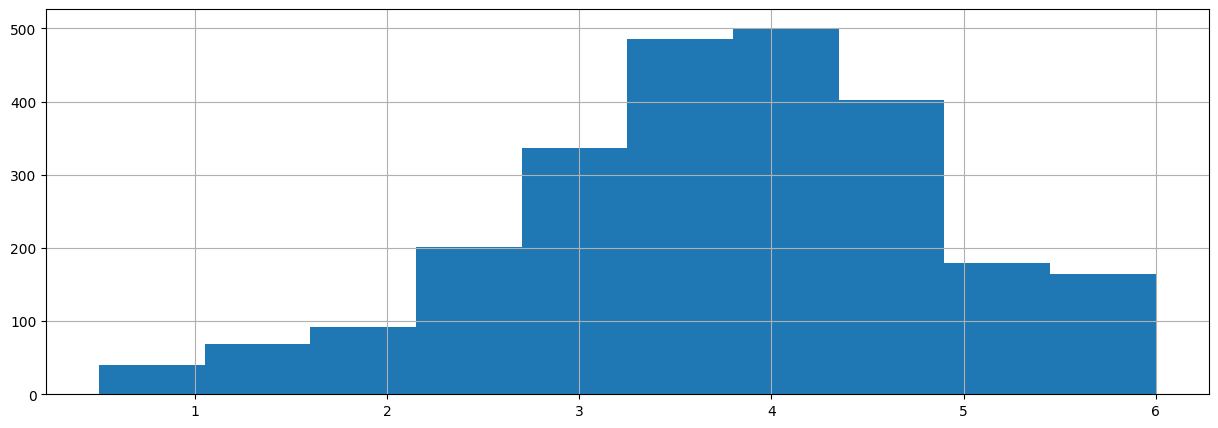

In [132]:
plt.figure(figsize=(15, 5))
train_scores['score'].hist()
plt.show()

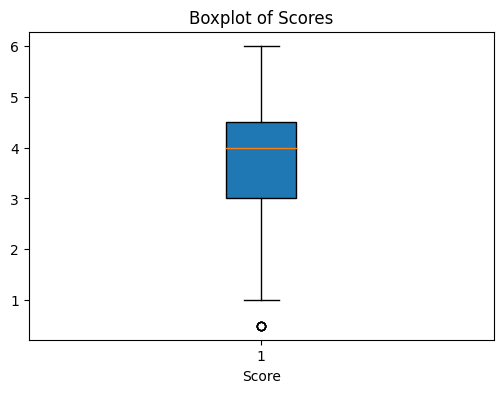

In [133]:
plt.figure(figsize=(6,4))
plt.boxplot(train_scores['score'], patch_artist=True)
plt.title('Boxplot of Scores')
plt.xlabel('Score')

plt.show()

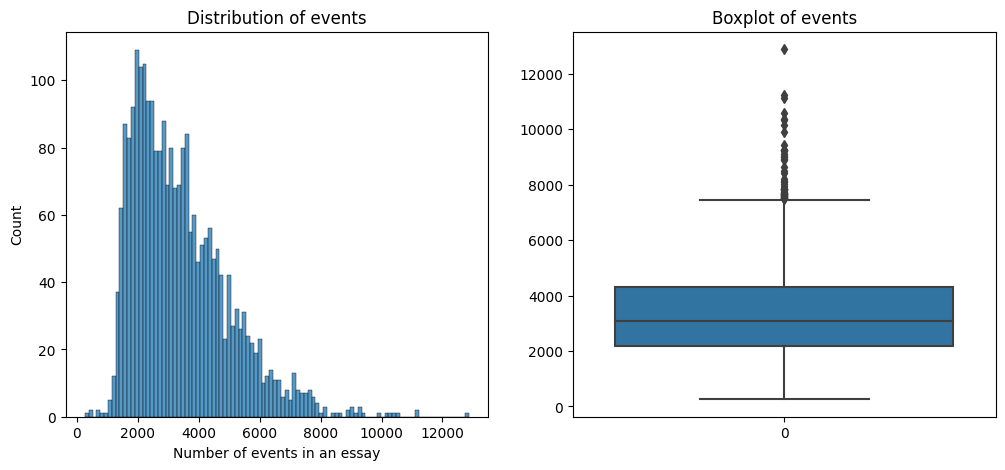

In [134]:
event_stats = train_logs.groupby("id")['event_id'].count()

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].set_title('Distribution of events')
ax[0].set_xlabel('Number of events in an essay')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

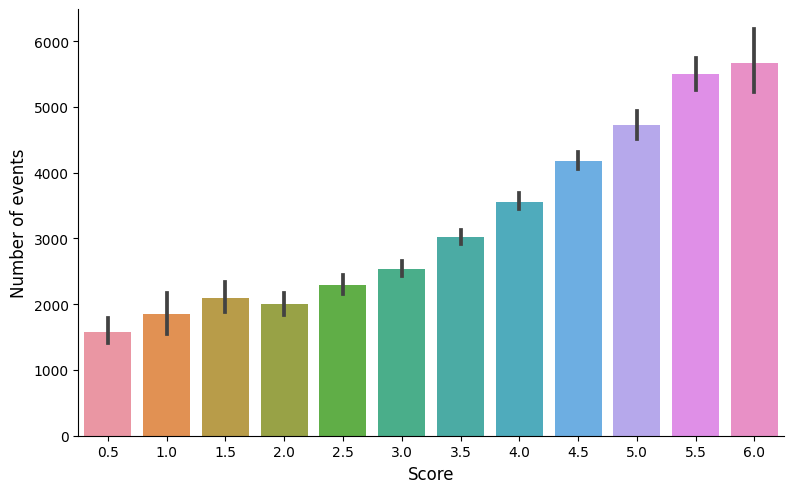

In [135]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.show()

# Prediction and features

In [136]:
train_df = pd.merge(train_logs, train_scores, on = "id", how = "inner")
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [137]:
df_agg_new = train_df.groupby(['id']).agg(
    #event_id_max=pd.NamedAgg(column="event_id", aggfunc="max"),
    action_time_mean=pd.NamedAgg(column="action_time", aggfunc="mean"),
    action_time_sum=pd.NamedAgg(column="action_time", aggfunc="sum"),
    action_time_min=pd.NamedAgg(column="action_time", aggfunc="min"),
    action_time_max=pd.NamedAgg(column="action_time", aggfunc="max"),
    word_count_max=pd.NamedAgg(column="word_count", aggfunc="max"),
    cursor_position_max=pd.NamedAgg(column="cursor_position", aggfunc="max"),
    cursor_position_mean=pd.NamedAgg(column="cursor_position", aggfunc="mean"),
    activity_count=pd.NamedAgg(column="activity", aggfunc="count"),
    text_change_counts = pd.NamedAgg(column="text_change", aggfunc="count"),
    down_event_counts = pd.NamedAgg(column="down_event", aggfunc="count"),
    up_event_counts = pd.NamedAgg(column="up_event", aggfunc="count"),
    score = pd.NamedAgg(column="score", aggfunc="max")
).reset_index()

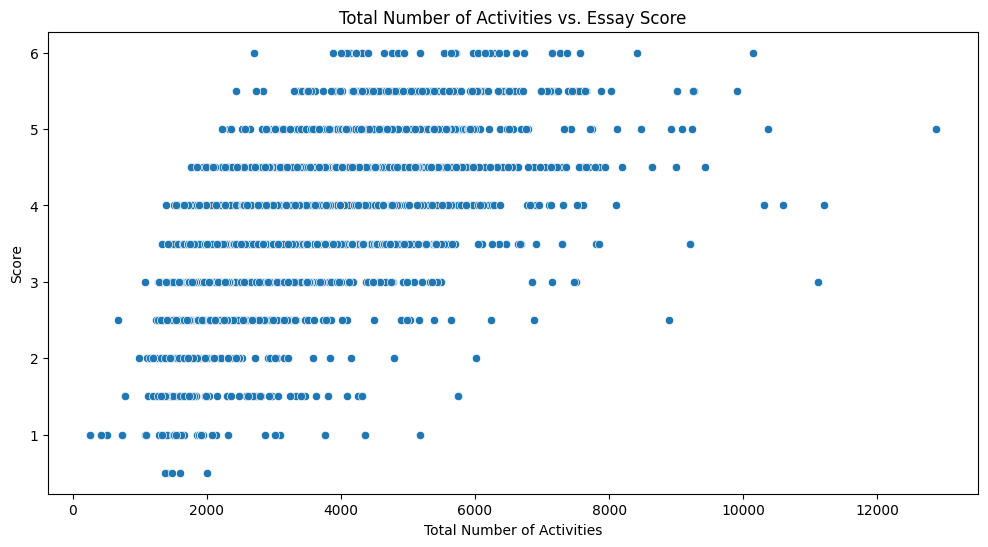

In [138]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='activity_count', y='score', data=df_agg_new)
plt.title('Total Number of Activities vs. Essay Score')
plt.xlabel('Total Number of Activities')
plt.ylabel('Score')
plt.show()

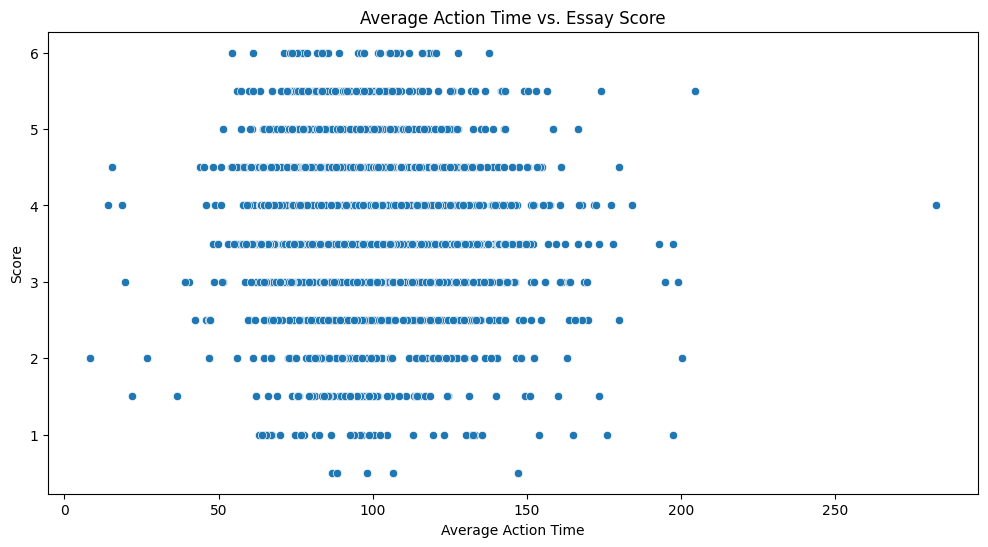

In [139]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='action_time_mean', y='score', data=df_agg_new)
plt.title('Average Action Time vs. Essay Score')
plt.xlabel('Average Action Time')
plt.ylabel('Score')
plt.show()

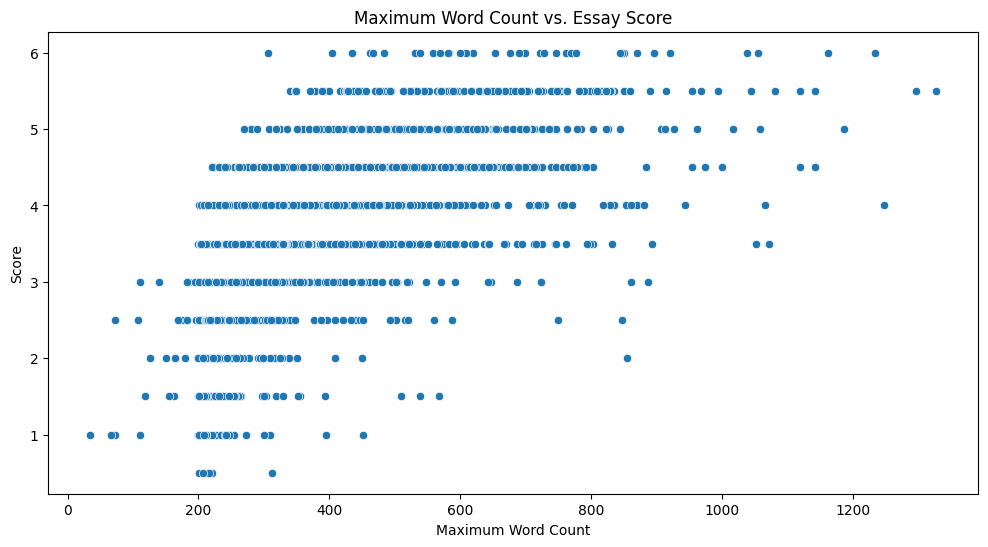

In [140]:
# Maximum word count vs. score
plt.figure(figsize=(12, 6))
sns.scatterplot(x='word_count_max', y='score', data=df_agg_new)
plt.title('Maximum Word Count vs. Essay Score')
plt.xlabel('Maximum Word Count')
plt.ylabel('Score')
plt.show()

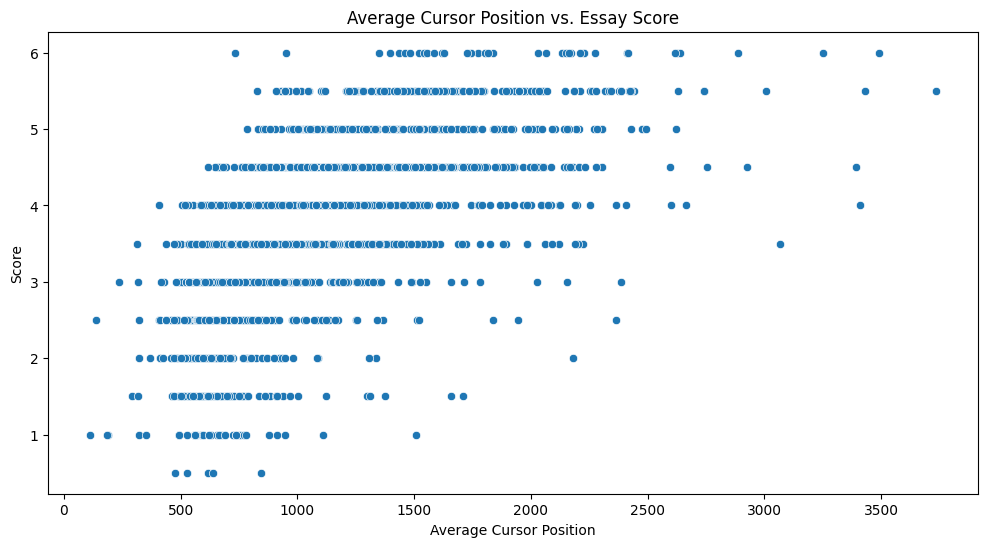

In [141]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='cursor_position_mean', y='score', data=df_agg_new)
plt.title('Average Cursor Position vs. Essay Score')
plt.xlabel('Average Cursor Position')
plt.ylabel('Score')
plt.show()

In [142]:
df_agg_new.head()

,id,action_time_mean,action_time_sum,action_time_min,action_time_max,word_count_max,cursor_position_max,cursor_position_mean,activity_count,text_change_counts,down_event_counts,up_event_counts,score
0,001519c8,116.246774,297243,0,2259,256,1539,711.163473,2557,2557,2557,2557,3.5
1,0022f953,112.221271,275391,0,1758,323,1676,776.205786,2454,2454,2454,2454,3.5
2,0042269b,101.837766,421201,0,3005,404,2291,731.611702,4136,4136,4136,4136,6.0
3,0059420b,121.848329,189596,0,806,206,1047,542.537275,1556,1556,1556,1556,2.0
4,0075873a,123.943896,313702,0,701,252,1402,600.050968,2531,2531,2531,2531,4.0


In [143]:
df_agg_new.shape

(2471, 13)

In [144]:
y = df_agg_new.score
X = df_agg_new.drop(['id','score'],axis=1)

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [146]:

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

cross val

In [149]:
# Define a function that compares the CV perfromance of a set of predetrmined models
def cv_comparison(models, X, y, cv):
    # Initiate a DataFrame for the averages and a list for all measures
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of
    # all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    cv_accuracies.columns = ["Linear Regression","Random Forest","Extreme Gradient Boost"]
    return cv_accuracies, maes, mses, r2s, accs

In [150]:
# Create the models to be tested
mlr_reg = LinearRegression()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb.XGBRegressor(random_state=42)

# Put the models in a list to be used for Cross-Validation
models = [mlr_reg, rf_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train, y_train, 4)



In [151]:
comp

,Linear Regression,Random Forest,Extreme Gradient Boost
Mean Absolute Error,0.5957,0.5727,0.6192
Mean Squared Error,0.6063,0.5482,0.6301
R^2,0.4271,0.4818,0.4055
Accuracy,83.9302,84.5513,83.2976


In [152]:
# Create DataFrame for all maes
maes_comp = pd.DataFrame(maes, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold',
                                                         '4th Fold'])

# Add a column for the averages
maes_comp['Average'] = np.round(maes_comp.mean(axis=1),4)

maes_comp

,1st Fold,2nd Fold,3rd Fold,4th Fold,Average
Linear Regression,0.6047,0.6232,0.5867,0.5682,0.5957
Random Forest,0.5752,0.5949,0.5793,0.5413,0.5727
Extreme Gradient Boost,0.6063,0.6716,0.6252,0.5735,0.6192


# HyperParameter Tuning with RandomSearch

In [153]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(100, 500, 5)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
#rf_criterion = ['squared_error','absolute_error']
rf_criterion = ['squared_error']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

In [154]:
# Create the model to be tuned
rf_base = RandomForestRegressor()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid,
                               n_iter = 50, cv = 3, verbose = 2, random_state = 42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# View the best parameters from the random search
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_impurity_decrease': 0.0,
 'max_features': 'log2',
 'max_depth': 8,
 'criterion': 'squared_error',
 'bootstrap': True}

In [155]:
# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(100, 500, 5)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Learning objective used
xgb_objective = ['reg:squarederror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

In [156]:
# Create the model to be tuned
xgb_base = xgb.XGBRegressor()

# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid,
                                n_iter = 50, cv = 3, verbose = 2,
                                random_state = 420, n_jobs = -1)

# Fit the random search model
xgb_random.fit(X_train, y_train)

# Get the optimal parameters
xgb_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'tree_method': 'approx',
 'objective': 'reg:squarederror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 4,
 'gamma': 0,
 'eta': 0.1}

# Training models with the best parameters

In [157]:
mlr_final = LinearRegression()

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 400,
                                 min_samples_split = 10,
                                 min_impurity_decrease = 0.0,
                                 max_features = 'log2',
                                 max_depth = 8,
                                 criterion = 'squared_error',
                                 bootstrap = True,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = xgb.XGBRegressor(tree_method = 'auto',
                         objective = 'reg:squarederror',
                         n_estimators = 200,
                         min_child_weight = 1,
                         max_depth = 6,
                         gamma = 0,
                         eta = 0.1,
                         random_state = 42)

# Train the models using 80% of the original data
mlr_final.fit(X_train, y_train)
rf_final.fit(X_train, y_train)
xgb_final.fit(X_train, y_train)




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

# Finding best features of corresponding models

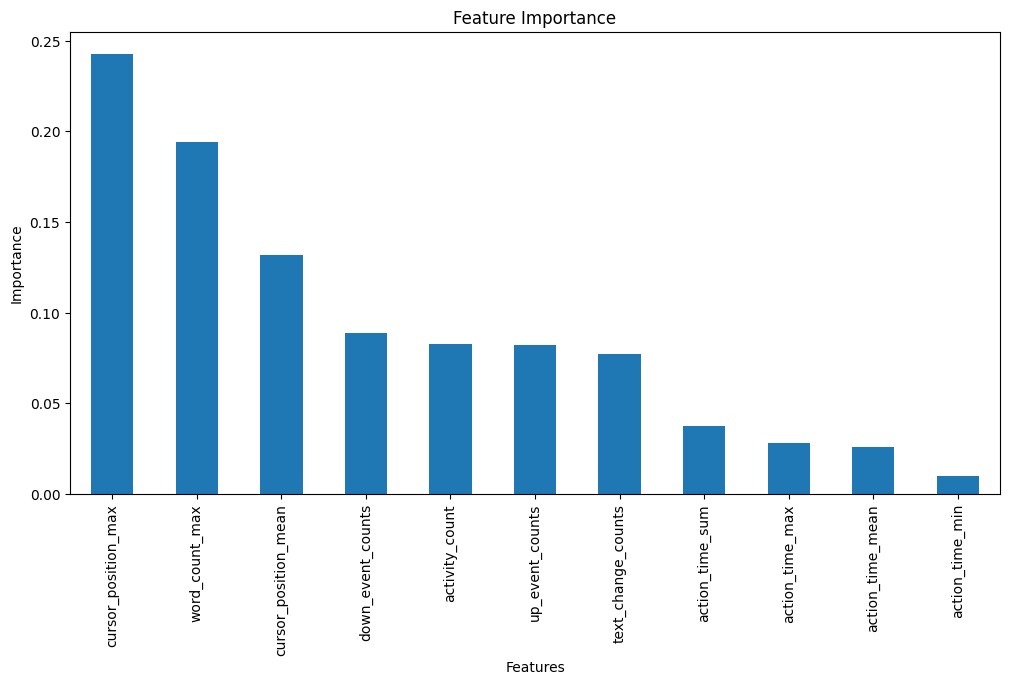

In [159]:
# for random forest finding best features
feature_importance = pd.Series(rf_final.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

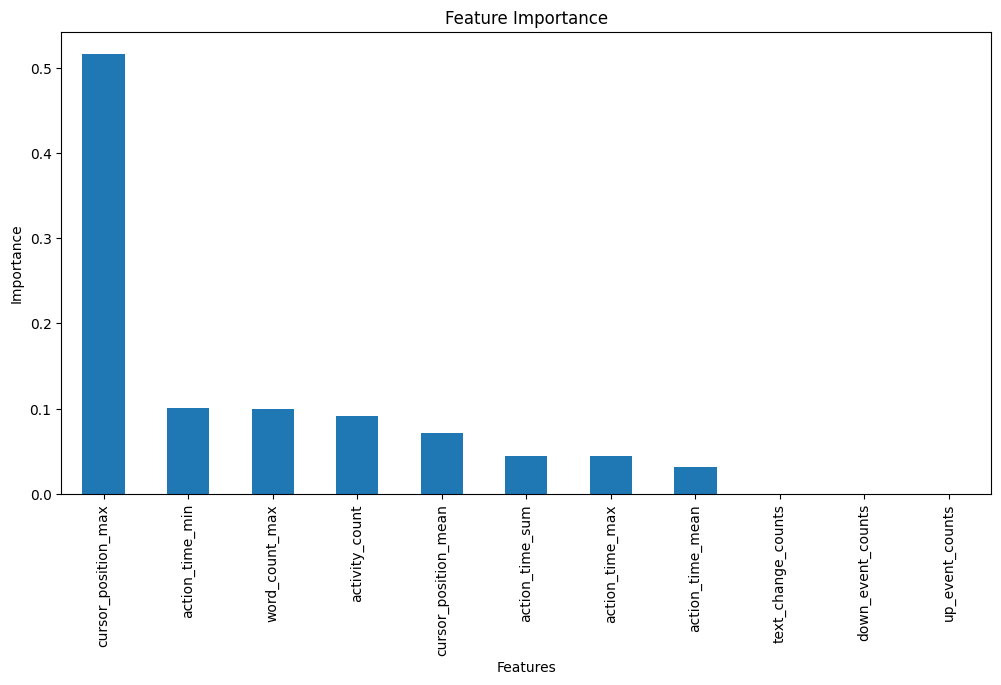

In [160]:
# for XGB finding best features
feature_importance = pd.Series(xgb_final.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# Final Comparision between the models on the hold out set

In [162]:
# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores

In [163]:
# Call the comparison function with the three final models
final_scores = final_comparison([mlr_final, rf_final, xgb_final], X_test, y_test)

# Adjust the column headers
final_scores.columns  = ['Linear Regression', 'Random Forest', 'Extreme Gradient Boosting']
final_scores

,Linear Regression,Random Forest,Extreme Gradient Boosting
Mean Absolute Error,0.5678,0.5265,0.5696
Mean Squared Error,0.5787,0.4924,0.5624
R^2,0.4367,0.5207,0.4525
Accuracy,80.2164,81.9956,80.8339
